In [1]:
import datetime as dt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import phik

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

## A. Loading Data

In [2]:
application_train = pd.read_csv(".\\Data\\final_project_DP_dataset\\application_train.csv")
application_test = pd.read_csv(".\\Data\\final_project_DP_dataset\\application_test.csv")
installments_payments = pd.read_csv(".\\Data\\final_project_DP_dataset\\installments_payments.csv")
credit_card_balance = pd.read_csv(".\\Data\\final_project_DP_dataset\\credit_card_balance.csv")

## B. EDA

### a. `installments_payments.csv`

`installment_payment.csv` lists out the repayment history of each of the loan that the applicant had with Home Credit Group. The table contains features like the amount of installment, how much did the client pay for each installments, etc.

**1. Description**

First, I will check the number of rows and columns. Then, I will count the number of applicants and repayments submitted in `installment_payments` using `SK_ID_CURR` and `SK_ID_PREV`. I would also count the number of applicants appearing in both `installments_payments` and `application_train`/`application_test`.

In [3]:
print(f'The shape of installments_payments.csv is: {installments_payments.shape}')
print('-' * 100)
print(f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(installments_payments.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(installments_payments.SK_ID_CURR.unique())}')
print('-' * 100)
print(f'Unique SK_ID_CURR in application_train: {application_train["SK_ID_CURR"].nunique()}')
print(f'Unique SK_ID_CURR in application_test: {application_test["SK_ID_CURR"].nunique()}')
print('-' * 100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')

The shape of installments_payments.csv is: (7744758, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in installments_payments.csv are: 549020
Number of unique SK_ID_CURR in installments_payments.csv are: 180734
----------------------------------------------------------------------------------------------------
Unique SK_ID_CURR in application_train: 246009
Unique SK_ID_CURR in application_test: 61502
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 144408
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 36325


In [4]:
installments_payments.head()

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0


<h5>Observations and Conclusions:</h5>

<ol><li>The installments_payments.csv file contains close to 7.7M datapoints, with 8 features. Out of these 8 features, 2 are SK_ID_CURR and SK_ID_PREV.
    <ul><li>SK_ID_PREV is the ID of previous credit in Home Credit related to loan in our sample.
    <li>SK_ID_CURR is the loan ID of client's current loan with Home Credit.
    <li>The rest of the features contain other stats such as DAYS_INSTALMENT, AMT_INSTALMENT, etc.
    </ul></li>
    <li>There are 549k unique previous loans in the installments_payments. These belong to 180k unique SK_ID_CURR, which are ID of applicants of current loan, out of which:
        <ul><li>There are 246k unique SK_ID_CURR in application_train, 144k previously had some form of loan with Home Credit.<br>
        <li>Similarly, there are 36k SK_ID_CURR in installments_payments which are present in application_test, out of 61k of application_test's unique SK_ID_CURR.</ul>

In [5]:
installments_payments.columns

Index(['SK_ID_PREV', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER',
       'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT',
       'AMT_PAYMENT', 'SK_ID_CURR'],
      dtype='object')

In [6]:
# Check the data types of the columns
print(f'Columns in installments_payments and their dtype:')
print('-' * 50)
for col in installments_payments.columns:
    print(f'{col} - {installments_payments[col].dtype}')

Columns in installments_payments and their dtype:
--------------------------------------------------
SK_ID_PREV - int64
NUM_INSTALMENT_VERSION - float64
NUM_INSTALMENT_NUMBER - int64
DAYS_INSTALMENT - float64
DAYS_ENTRY_PAYMENT - float64
AMT_INSTALMENT - float64
AMT_PAYMENT - float64
SK_ID_CURR - float64


Here is an explanation of each column in `installments_payments.csv`:

1. **SK_ID_PREV**: The unique identifier of a previous credit in Home Credit related to the current loan. It establishes a link between historical credit records and loans in the dataset.
2. **SK_ID_CURR**: The unique identifier of the current loan.
3. **NUM_INSTALMENT_VERSION**: Indicates the version of the installment payment calendar for the previous credit. A value of 0 typically denotes a credit card payment calendar. Changes in this version from month to month suggest modifications to the installment schedule or related parameters.
4. **NUM_INSTALMENT_NUMBER**: On which installment we observe payment.
5. **DAYS_INSTALMENT**: Reflects the scheduled due date for the installment payment of the previous credit, expressed as days relative to the application date of the current loan. A negative value indicates days before the current loan application.
6. **DAYS_ENTRY_PAYMENT**: Records the actual date on which the installment payment for the previous credit was paid, also expressed as days relative to the application date of the current loan.
7. **AMT_INSTALMENT**: The prescribed amount for the installment payment of the previous credit. This represents the expected payment amount according to the original agreement.
8. **AMT_PAYMENT**: The actual amount paid by the client for the specific installment of the previous credit.

In [7]:
with pd.option_context('display.float_format', '{:.1f}'.format):
    print(installments_payments.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis = 1).describe())

       NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
count               7744758.0              7744758.0        7744758.0   
mean                      0.8                   19.9          -1055.7   
std                       1.0                   27.6            801.0   
min                       0.0                    1.0          -2922.0   
25%                       0.0                    4.0          -1677.0   
50%                       1.0                    9.0           -842.0   
75%                       1.0                   21.0           -369.0   
max                     178.0                  275.0             -2.0   

       DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
count           7743119.0       7744757.0    7743119.0  
mean              -1064.3         16724.8      16853.9  
std                 800.6         49977.5      54076.0  
min               -3160.0             0.0          0.0  
25%               -1686.0          4050.0       3375.0  


**2. Checking duplicated values**

In [8]:
print(f'Number of duplicate values in installments_payments table: {installments_payments.shape[0] - installments_payments.duplicated().shape[0]}')

Number of duplicate values in installments_payments table: 0


**3. NaN Percentage and NaN Values Checking**

In [9]:
def percentage_null(df):
    return df.isnull().sum() / df.shape[0]*100

In [10]:
missing_percentage = percentage_null(installments_payments)

missing_percentage_table = pd.DataFrame({
    'Column': missing_percentage.index,
    'Percentage of Missing Values': missing_percentage.values
}).reset_index(drop = True)

print(missing_percentage_table)

                   Column  Percentage of Missing Values
0              SK_ID_PREV                      0.000000
1  NUM_INSTALMENT_VERSION                      0.000000
2   NUM_INSTALMENT_NUMBER                      0.000000
3         DAYS_INSTALMENT                      0.000000
4      DAYS_ENTRY_PAYMENT                      0.021163
5          AMT_INSTALMENT                      0.000013
6             AMT_PAYMENT                      0.021163
7              SK_ID_CURR                      0.000013


##### Observations and Conclusions:

1. There are only 4 columns that contains NaN values of the 8 columns from installment_payments.
2. These columns also contain very minimal proportion of NaN values, so I will check the rows with NaN values and find a way to handle them.  

In [11]:
installments_payments.loc[installments_payments['SK_ID_CURR'].isnull()]

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
7744757,2657771,0.0,94,-4.0,NaN,NaN,NaN,NaN


**Note**: There is only one row containing NaN value in SK_ID_CURR column. This row also contains NaN values in DAYS_ENTRY_PAYMENT, AMT_INSTALMENT and AMT_PAYMENT. It seems like the missing value occurs due to system error or data entry mistakes. I will drop this row later since it won't affect the outcome. 

In [12]:
installments_payments.loc[installments_payments['DAYS_ENTRY_PAYMENT'].isnull()]

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
20968,2745338,0.0,49,-992.0,NaN,67.5,NaN,280024.0
20969,2745338,0.0,48,-1023.0,NaN,67.5,NaN,280024.0
20970,2745338,0.0,50,-963.0,NaN,67.5,NaN,280024.0
23789,1724459,1.0,11,-3.0,NaN,43839.0,NaN,135730.0
30552,1376802,0.0,2,-733.0,NaN,0.0,NaN,239362.0
...,...,...,...,...,...,...,...,...
7743511,1088123,0.0,68,-1727.0,NaN,67.5,NaN,98758.0
7743512,1088123,0.0,70,-1668.0,NaN,67.5,NaN,98758.0
7743514,1088123,0.0,69,-1699.0,NaN,67.5,NaN,98758.0
7743516,1088123,0.0,71,-1638.0,NaN,67.5,NaN,98758.0


In [13]:
missing_data_in_days_entry_payment = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull()]
missing_in_both_columns = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull() & installments_payments['AMT_PAYMENT'].isnull()]

print(missing_data_in_days_entry_payment.index.equals(missing_in_both_columns.index))

True


**Note**: The rows containing NaN values in DAYS_ENTRY_PAYMENT also contain NaN values in AMT_PAYMENT. The DAYS_ENTRY_PAYMENT record a scheduled due date on which the customer is supposed to pay the installment, and the AMT_PAYMENT record the amount of payment the customer has paid. When both features are missing in one row, I assume that the customer has not paid the due amount during that payment period, or their loan has been repaid early, and thus, the amount paid and the day on which they paid cannot be recorded (missing not at random). However, the missing values are of a minimal proportion, so I will leave these values as they are. 

**4. Merging the TARGETS from application_train to installments_payments table.**

Merge the `installments_payments` table with the TARGET variable in `application_train`. TARGET is a dependent variable used to determine whether a profile is consider high-risk or not.

In [14]:
installments_merged = application_train[['SK_ID_CURR', 'TARGET']].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')

installments_merged.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,278621,0,1810518.0,1.0,2.0,-686.0,-690.0,98356.995,98356.995
1,278621,0,1810518.0,1.0,3.0,-656.0,-661.0,98356.995,98356.995
2,278621,0,2396755.0,1.0,4.0,-2220.0,-2226.0,6737.310,6737.310
3,278621,0,2396755.0,1.0,9.0,-2070.0,-2071.0,6737.310,6737.310
4,278621,0,2396755.0,1.0,5.0,-2190.0,-2199.0,6737.310,6737.310


In [15]:
def print_percentiles(data, column_name, percentiles = None):
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0, 80, 25)) + list(range(90, 101, 2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

In [16]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], 
                              scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

***Plotting Continuous Variables***

- Distribution of Continuous Variable `DAYS_INSTALMENT`

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_INSTALMENT is -2922.0
The 2th percentile value of DAYS_INSTALMENT is -2750.0
The 4th percentile value of DAYS_INSTALMENT is -2611.0
The 6th percentile value of DAYS_INSTALMENT is -2497.0
The 8th percentile value of DAYS_INSTALMENT is -2400.0
The 10th percentile value of DAYS_INSTALMENT is -2310.0
The 25th percentile value of DAYS_INSTALMENT is -1678.0
The 50th percentile value of DAYS_INSTALMENT is -843.0
The 75th percentile value of DAYS_INSTALMENT is -370.0
The 100th percentile value of DAYS_INSTALMENT is -2.0
----------------------------------------------------------------------------------------------------


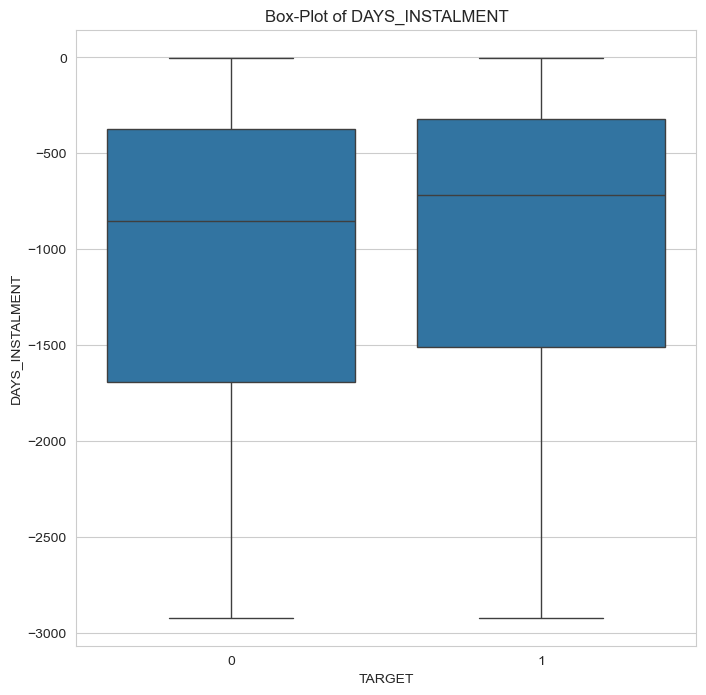

----------------------------------------------------------------------------------------------------


In [17]:
print_percentiles(installments_merged, 'DAYS_INSTALMENT', percentiles = list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8, 8), scale_limits = [-40000, 400])
print('-' * 100)

- Distribution of Continuous Variable `DAYS_ENTRY_PAYMENT`

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_ENTRY_PAYMENT is -3129.0
The 2th percentile value of DAYS_ENTRY_PAYMENT is -2755.0
The 4th percentile value of DAYS_ENTRY_PAYMENT is -2617.0
The 6th percentile value of DAYS_ENTRY_PAYMENT is -2505.0
The 8th percentile value of DAYS_ENTRY_PAYMENT is -2408.0
The 10th percentile value of DAYS_ENTRY_PAYMENT is -2318.0
The 25th percentile value of DAYS_ENTRY_PAYMENT is -1687.0
The 50th percentile value of DAYS_ENTRY_PAYMENT is -851.0
The 75th percentile value of DAYS_ENTRY_PAYMENT is -379.0
The 100th percentile value of DAYS_ENTRY_PAYMENT is -2.0
----------------------------------------------------------------------------------------------------


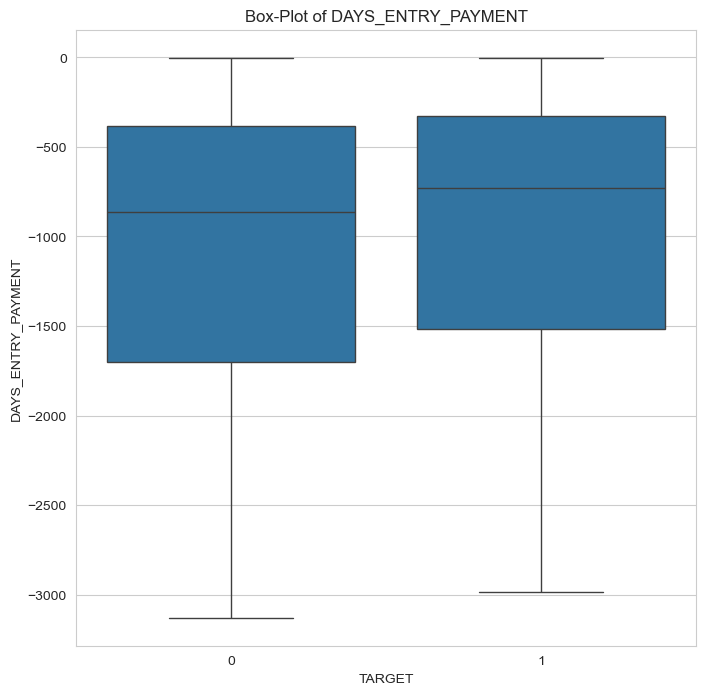

----------------------------------------------------------------------------------------------------


In [18]:
print_percentiles(installments_merged, 'DAYS_ENTRY_PAYMENT', percentiles = list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(installments_merged, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8, 8), scale_limits = [-40000, 400])
print('-' * 100)

**5. Outliers and Potential Problems**

Minimum value of `AMT_INSTALMENT` is 0. I will check the rows where `AMT_INSTALMENT` = 0.

In [19]:
installments_merged.loc[installments_merged['AMT_INSTALMENT'] == 0]

,SK_ID_CURR,TARGET,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
79086,287080,0,2287929.0,0.0,100.0,-406.0,NaN,0.0,NaN
79087,287080,0,2287929.0,0.0,101.0,-376.0,NaN,0.0,NaN
114551,239362,0,1376802.0,0.0,2.0,-733.0,NaN,0.0,NaN
168767,63015,0,1171606.0,1.0,8.0,-2922.0,-467.0,0.0,6.300
168768,63015,0,1171606.0,1.0,8.0,-2922.0,-2948.0,0.0,5254.425
...,...,...,...,...,...,...,...,...,...
5022865,79780,0,1363769.0,1.0,1.0,-2887.0,-2917.0,0.0,5213.295
5022867,79780,0,1363769.0,1.0,3.0,-2827.0,-2856.0,0.0,5213.295
5056717,38614,0,2204278.0,0.0,80.0,-857.0,NaN,0.0,NaN
5418954,283661,0,1948792.0,2.0,5.0,-68.0,NaN,0.0,NaN


There are numerous instances in the data where `AMT_INSTALMENT` equals 0. While this is not necessarily indicative of data entry errors or outliers, it can occur under several legitimate scenarios:

**1. Grace Periods and Promotional Offers**
- Many loans include a **grace period** during which the client is not required to make payments. 
- Similarly, promotional offers, such as "no installment payment for the first few months," could result in scheduled installments of 0 during these periods.

**2. Revolving Credit (e.g., Credit Cards)**
- For revolving credit products, such as credit cards, installment amounts can vary from month to month. In some cases, the installment might be 0, particularly if:
  - The client has fully paid off the balance.
  - No new charges have been incurred during that period.

**3. Early Repayments or Lump-Sum Payments**
- If a loan is repaid early, either partially or in full, future scheduled installment amounts (`AMT_INSTALMENT`) may be set to 0 since no further payments are required. This could lead to the following patterns:
  - **Early Repayment Within Grace Periods**:  
    - If the client pays the balance early during a grace or promotional period, the actual payment date (`DAYS_ENTRY_PAYMENT`) would be earlier than the scheduled due date (`DAYS_INSTALMENT > DAYS_ENTRY_PAYMENT`).  
    - The corresponding installment amount recorded in `AMT_INSTALMENT` would be 0.
  - **Full Loan Repayment**:  
    - For loans repaid in full before their due date, `AMT_INSTALMENT` would be 0 for subsequent periods. Additionally:
      - `DAYS_ENTRY_PAYMENT` and `AMT_PAYMENT` may be null, as no payments occur during these periods.

**4. Potential Data Irregularities or Outliers**
- Although the above scenarios explain many cases, irregularities may still exist. For example:
  - If `AMT_INSTALMENT = 0` but the actual payment date (`DAYS_ENTRY_PAYMENT`) is **after** the scheduled due date (`DAYS_INSTALMENT`), it could indicate inconsistencies in the data or unusual payment behavior.
- Further investigation is necessary to determine if such instances are valid or represent outliers.

In [20]:
installments_merged[(installments_merged['AMT_INSTALMENT'] == 0) & 
    (installments_merged['DAYS_ENTRY_PAYMENT'] > installments_merged['DAYS_INSTALMENT'])]

,SK_ID_CURR,TARGET,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
168767,63015,0,1171606.0,1.0,8.0,-2922.0,-467.0,0.0,6.300
1810559,26563,0,1822101.0,1.0,12.0,-1875.0,-380.0,0.0,1.305
2968083,24901,1,2247515.0,1.0,10.0,-2818.0,-611.0,0.0,308.700
2968188,24901,1,2247515.0,1.0,10.0,-2818.0,-2817.0,0.0,2410.920
3815792,227706,0,2311125.0,1.0,35.0,-1196.0,-1195.0,0.0,41434.290
3815841,227706,0,2311125.0,1.0,21.0,-1616.0,-1615.0,0.0,41434.290
3876014,256658,0,1936690.0,1.0,10.0,-2643.0,-2642.0,0.0,3870.000
3876016,256658,0,1936690.0,1.0,10.0,-2643.0,-418.0,0.0,1.530
4572001,296339,0,2491127.0,1.0,11.0,-2086.0,-2085.0,0.0,7314.660
4572008,296339,0,2491127.0,1.0,12.0,-2056.0,-515.0,0.0,3.960


**Note**: Since the number of these rows are minimal, I will keep them as they are.

In [21]:
def count_unique_values(df: pd.DataFrame, column: str):
    value_counts = df[column].value_counts().reset_index()
    
    value_counts.columns = ['Value', 'Count']
    
    filtered_value_counts = value_counts[value_counts['Count'] == 1]
    
    return filtered_value_counts

In [22]:
# List down the values that only appear once
count_unique_values(installments_merged, 'NUM_INSTALMENT_VERSION')

,Value,Count
47,68.0,1
48,178.0,1
49,52.0,1
50,48.0,1
51,47.0,1
52,49.0,1
53,50.0,1


**Note**: We can see that there are some values in `NUM_INSTALMENT_VERSION` that only appears once. Since `NUM_INSTALMENT_VERSION` contains discrete values, I will drop the rows containing outliers. 

**6. Correlation Matrix of Features**

In [23]:
def correlation_heatmap(data, features, figsize = (10, 8), cmap = 'Blues', annot = False):
    corr_matrix = data[features].corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize = figsize)
    sns.heatmap(corr_matrix, mask = mask, annot = annot, fmt = '.2f', cmap = cmap, 
                cbar = True, square = True, linewidths = 0.5)
    plt.title("Correlation Heatmap for Numerical Features", fontsize = 14)
    plt.show()

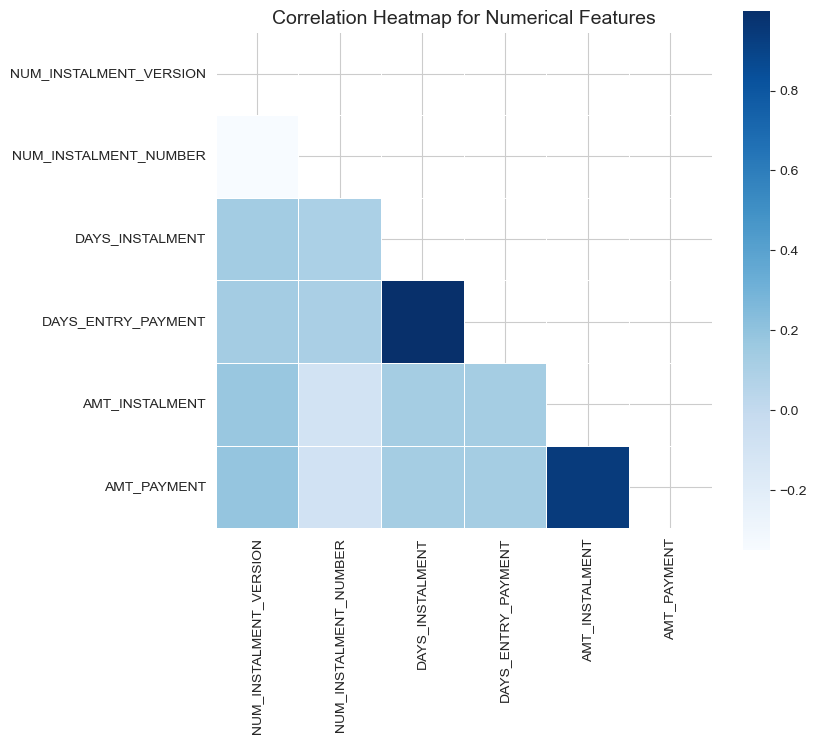

In [24]:
# Check the correlation between features
features = ['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 
            'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 
            'AMT_INSTALMENT', 'AMT_PAYMENT']

correlation_heatmap(installments_merged, features, figsize=(8, 7), cmap='Blues', annot=False)

From the heatmap above, we can see that there are some set of highly correlated features:
- `AMT_INSTALMENT` and `AMT_PAYMENT`
- `DAYS_INSTALMENT` and `DAYS_ENTRY_PAYMENT`

### b. `credit_card_balance.csv`

This table consists of the monthly data related to any or multiple Credit Cards that the applicant had with the Home Credit Group. The table contains fields like balance, the credit limit, amount of drawings, etc. for each month of the credit card.

**1. Description**

First, I will check the number of rows and columns. Then, I will count the number of applicants and repayments submitted in `credit_card_balance` using `SK_ID_CURR` and `SK_ID_PREV`. I would also count the number of applicants appearing in both `credit_card_balance` and `application_train`/`application_test`.

In [25]:
print(f'The shape of credit_card_balance.csv is: {credit_card_balance.shape}')
print('-' * 100)
print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(credit_card_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(credit_card_balance.SK_ID_CURR.unique())}')
print('-' * 100)
print(f'Unique SK_ID_CURR in application_train: {application_train["SK_ID_CURR"].nunique()}')
print(f'Unique SK_ID_CURR in application_test: {application_test["SK_ID_CURR"].nunique()}')
print('-' * 100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')

The shape of credit_card_balance.csv is: (3227965, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 87452
Number of unique SK_ID_CURR in credit_card_balance.csv are: 86905
----------------------------------------------------------------------------------------------------
Unique SK_ID_CURR in application_train: 246009
Unique SK_ID_CURR in application_test: 61502
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 69536
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 17369


In [26]:
credit_card_balance.head()

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.0,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0,87788
1,2582071,-82,16809.210,67500,0.0,0.0,0.0,0.0,3375.0,9000.0,9000.0,15488.685,16809.210,16809.210,0.0,0,0.0,0.0,18.0,Active,0,0,87788
2,2582071,-84,27577.890,67500,0.0,0.0,0.0,0.0,3375.0,4500.0,4500.0,26125.020,27577.890,27577.890,0.0,0,0.0,0.0,16.0,Active,0,0,87788
3,2582071,-7,65159.235,45000,0.0,0.0,0.0,0.0,2250.0,2250.0,2250.0,60301.170,65609.235,65609.235,0.0,0,0.0,0.0,63.0,Active,0,0,87788
4,2582071,-59,70475.850,67500,24750.0,24750.0,0.0,0.0,3375.0,4500.0,4500.0,63975.015,70475.850,70475.850,4.0,4,0.0,0.0,41.0,Active,0,0,87788


<h5>Observations and Conclusions:</h5>

<ol><li>The credit_card_balance.csv file contains close to 3.22M datapoints, with 23 features. Out of these 23 features, 2 are SK_ID_CURR and SK_ID_PREV. The rest of the features contain the statistics about each month's Credit Card status, such as Balance Amount, Amount of Drawings, Number of Drawings, Status, etc.
    </ul></li>
    <li>There are 87k unique Credit Cards whose details are in this table, out of which: 
        <ul><li>There are 86k unique SK_ID_CURR. What this means is that most of the applicants had just 1 credit card with them, and only few of them had more than 1. These SK_ID_CURR are the ID of the applicants who have currently applied for loan.<br>
        <li>Out of the 86k unique SK_ID_CURR, 69.5k of these applicants belong to the training set, and 17.3k belong to the test application set.</ul>

In [27]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF', 'SK_ID_CURR'],
      dtype='object')

In [28]:
# Check the data type of each column
print(f'Columns in credit_card_balance and their dtype:')
print('-' * 50)
for col in credit_card_balance.columns:
    print(f'{col} - {credit_card_balance[col].dtype}')

Columns in credit_card_balance and their dtype:
--------------------------------------------------
SK_ID_PREV - int64
MONTHS_BALANCE - int64
AMT_BALANCE - float64
AMT_CREDIT_LIMIT_ACTUAL - int64
AMT_DRAWINGS_ATM_CURRENT - float64
AMT_DRAWINGS_CURRENT - float64
AMT_DRAWINGS_OTHER_CURRENT - float64
AMT_DRAWINGS_POS_CURRENT - float64
AMT_INST_MIN_REGULARITY - float64
AMT_PAYMENT_CURRENT - float64
AMT_PAYMENT_TOTAL_CURRENT - float64
AMT_RECEIVABLE_PRINCIPAL - float64
AMT_RECIVABLE - float64
AMT_TOTAL_RECEIVABLE - float64
CNT_DRAWINGS_ATM_CURRENT - float64
CNT_DRAWINGS_CURRENT - int64
CNT_DRAWINGS_OTHER_CURRENT - float64
CNT_DRAWINGS_POS_CURRENT - float64
CNT_INSTALMENT_MATURE_CUM - float64
NAME_CONTRACT_STATUS - object
SK_DPD - int64
SK_DPD_DEF - int64
SK_ID_CURR - int64


In [29]:
# Check unique values in categorical columns 
for col in credit_card_balance.columns:
    if credit_card_balance[col].dtype == 'object':
        print(f"Column: {col}")
        print(credit_card_balance[col].unique())
        print()  

Column: NAME_CONTRACT_STATUS
['Active' 'Signed' 'Completed' 'Sent proposal' 'Demand' 'Refused'
 'Approved']



***Histogram of Object Columns***

In [30]:
def plot_object_col_percent(data, title, col, tight_layout=True, figsize= (10, 5), rotation=0):
    plt.figure(figsize=figsize)
    sns.barplot(data[col].value_counts(normalize=True).values*100, orient='h')
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.yticks(range(len(data[col].value_counts().index)), data[col].value_counts(normalize=True).index)
    plt.xlabel('Percent')
    if tight_layout:
        plt.tight_layout()
    plt.show()

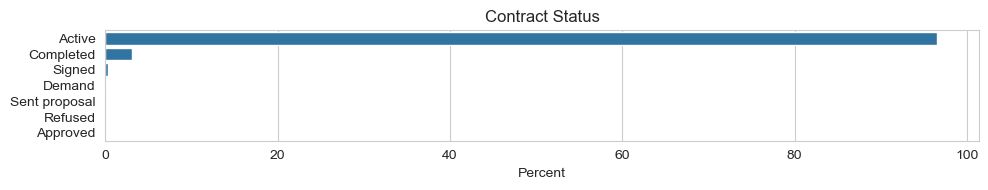

In [31]:
plot_object_col_percent(credit_card_balance, 'Contract Status', 'NAME_CONTRACT_STATUS', figsize=(10, 2))

**Note**: Most of the balance recorded belong "Active" or "Completed" credit cards. 

Here is an explanation of each column in `credit_card_balance.csv`:

1. **SK_ID_PREV**: Unique identifier for the previous credit related to the loan in our dataset. Each loan in our sample can be linked to one or more previous credits.
2. **SK_ID_CURR**: Unique identifier for the loan in the current dataset.
3. **MONTHS_BALANCE**: Month of balance relative to the application date. A value of `-1` indicates the most recent balance month.
4. **AMT_BALANCE**: The balance amount during the month of the previous credit.
5. **AMT_CREDIT_LIMIT_ACTUAL**: The credit card limit during the month of the previous credit.
6. **AMT_DRAWINGS_ATM_CURRENT**: The amount withdrawn from an ATM during the month of the previous credit.
7. **AMT_DRAWINGS_CURRENT**: The total amount withdrawn during the month of the previous credit.
8. **AMT_DRAWINGS_OTHER_CURRENT**: The amount withdrawn through other means during the month of the previous credit.
9. **AMT_DRAWINGS_POS_CURRENT**: The amount spent on point-of-sale (POS) purchases during the month of the previous credit.
10. **AMT_INST_MIN_REGULARITY**: The minimum installment amount required for the month of the previous credit.
11. **AMT_PAYMENT_CURRENT**: The amount paid by the client during the month of the previous credit.
12. **AMT_PAYMENT_TOTAL_CURRENT**: The total amount paid by the client during the month of the previous credit.
13. **AMT_RECEIVABLE_PRINCIPAL**: The principal amount receivable on the previous credit.
14. **AMT_RECEIVABLE**: The total amount receivable on the previous credit, including the principal.
15. **AMT_TOTAL_RECEIVABLE**: The total amount receivable on the previous credit, including interest and fees.
16. **CNT_DRAWINGS_ATM_CURRENT**: The number of ATM withdrawals during the month of the previous credit.
17. **CNT_DRAWINGS_CURRENT**: The total number of withdrawals during the month of the previous credit.
18. **CNT_DRAWINGS_OTHER_CURRENT**: The number of withdrawals through other means during the month of the previous credit.
19. **CNT_DRAWINGS_POS_CURRENT**: The number of purchases made at POS terminals during the month of the previous credit.
20. **CNT_INSTALMENT_MATURE_CUM**: The cumulative number of installments paid on the previous credit.
21. **NAME_CONTRACT_STATUS**: The contract status of the previous credit (e.g., active, signed, etc.).
22. **SK_DPD**: The number of days past due during the month of the previous credit.
23. **SK_DPD_DEF**: The number of days past due (excluding low-value loan amounts) during the month of the previous credit.

In [32]:
with pd.option_context('display.float_format', '{:.1f}'.format):
    print(credit_card_balance.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis=1).describe())

       MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
count       3227965.0    3227965.0                3227965.0   
mean            -34.7      59073.3                 152953.6   
std              26.6     106613.7                 163709.2   
min             -96.0    -420250.2                      0.0   
25%             -56.0          0.0                  45000.0   
50%             -28.0          0.0                 112500.0   
75%             -11.0      90405.5                 180000.0   
max              -1.0    1354829.3                1350000.0   

       AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
count                 2622211.0             3227965.0   
mean                     6024.3                7494.1   
std                     28421.2               33967.4   
min                     -6827.3               -6211.6   
25%                         0.0                   0.0   
50%                         0.0                   0.0   
75%                         0.0  

**Notes**: The statistics seem normal, except for the max value in `AMT_PAYMENT_CURRENT`. This could potentially be an outlier. 

**2. Checking duplicated values**

In [33]:
credit_card_balance.shape[0] - credit_card_balance.duplicated().shape[0]

0

**3. NaN Percentage and NaN Values Checking**

In [34]:
missing_percent = percentage_null(credit_card_balance)

missing_percentage_df = pd.DataFrame({
    'Column': missing_percent.index,
    'Percentage of Missing Values': missing_percent.values
}).reset_index(drop = True)

print(missing_percentage_df)

                        Column  Percentage of Missing Values
0                   SK_ID_PREV                      0.000000
1               MONTHS_BALANCE                      0.000000
2                  AMT_BALANCE                      0.000000
3      AMT_CREDIT_LIMIT_ACTUAL                      0.000000
4     AMT_DRAWINGS_ATM_CURRENT                     18.765817
5         AMT_DRAWINGS_CURRENT                      0.000000
6   AMT_DRAWINGS_OTHER_CURRENT                     18.765817
7     AMT_DRAWINGS_POS_CURRENT                     18.765817
8      AMT_INST_MIN_REGULARITY                      8.190423
9          AMT_PAYMENT_CURRENT                     19.210029
10   AMT_PAYMENT_TOTAL_CURRENT                      0.000000
11    AMT_RECEIVABLE_PRINCIPAL                      0.000000
12               AMT_RECIVABLE                      0.000000
13        AMT_TOTAL_RECEIVABLE                      0.000000
14    CNT_DRAWINGS_ATM_CURRENT                     18.765817
15        CNT_DRAWINGS_C

##### Observations and Conclusions:

1. Out of the 23 features, 9 of these features contain some NaN values.
2. 7 of these features have close to 20% NaN values. These features are mostly related to the Amounts of Drawing and Counts of Drawings. Other two of the features are related to the installments statistics.
3. There are some columns having the same percentage of missing values. I will investigate further to check whether it is some sort of pattern.

`AMT_INST_MIN_REGULARITY` and `CNT_INSTALMENT_MATURE_CUM`

In [35]:
credit_card_balance.loc[credit_card_balance['AMT_INST_MIN_REGULARITY'].isnull()]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
218,1235299,-48,0.000,90000,0.0,0.000,0.0,0.000,NaN,0.0,0.0,0.000,0.000,0.000,0.0,0,0.0,0.0,NaN,Signed,0,0,127985
259,1235299,-47,93293.370,90000,90000.0,90000.000,0.0,0.000,NaN,0.0,0.0,90000.000,90602.370,90602.370,2.0,2,0.0,0.0,NaN,Active,0,0,127985
282,1985699,-35,7632.225,90000,0.0,10327.725,0.0,10327.725,NaN,2695.5,2695.5,7632.225,7632.225,7632.225,0.0,7,0.0,7.0,NaN,Active,0,0,178156
292,1985699,-37,0.000,90000,0.0,0.000,0.0,0.000,NaN,NaN,0.0,0.000,0.000,0.000,0.0,0,0.0,0.0,NaN,Active,0,0,178156
306,1985699,-36,0.000,90000,0.0,0.000,0.0,0.000,NaN,NaN,0.0,0.000,0.000,0.000,0.0,0,0.0,0.0,NaN,Active,0,0,178156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204076,1792525,-22,48043.665,180000,67500.0,67500.000,0.0,0.000,NaN,22500.0,22500.0,45000.000,46698.165,46698.165,1.0,1,0.0,0.0,NaN,Active,0,0,20279
3204079,1792525,-26,0.000,180000,NaN,0.000,NaN,NaN,NaN,NaN,0.0,0.000,0.000,0.000,NaN,0,NaN,NaN,NaN,Active,0,0,20279
3204081,1792525,-25,0.000,180000,NaN,0.000,NaN,NaN,NaN,NaN,0.0,0.000,0.000,0.000,NaN,0,NaN,NaN,NaN,Active,0,0,20279
3210108,1294711,-24,14760.000,765000,0.0,14760.000,0.0,14760.000,NaN,NaN,0.0,14760.000,14760.000,14760.000,0.0,1,0.0,1.0,NaN,Active,0,0,137812


In [36]:
missing_data_in_min_regularity = credit_card_balance[credit_card_balance['AMT_INST_MIN_REGULARITY'].isnull()]
missing_in_both = credit_card_balance[credit_card_balance['AMT_INST_MIN_REGULARITY'].isnull() & credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].isnull()]

print(missing_data_in_min_regularity.index.equals(missing_in_both.index))

True


Values in `AMT_INST_MIN_REGULARITY` and `CNT_INSTALMENT_MATURE_CUM` can be both missing under these cases:

1. **Inactive Contract**: The `NAME_CONTRACT_STATUS` column indicates the credit is inactive.
2. **No Usage**: The account shows zero balance (`AMT_BALANCE`) and/or zero credit limit (`AMT_CREDIT_LIMIT_ACTUAL`), indicating no activity during the period. No loan, thus no repayment required,
3. **Closed or Dormant Account**: The account has missing balance (`AMT_BALANCE`) and no recent activity (`MONTHS_BALANCE` equals 0), suggesting it was closed or dormant.

Values in `AMT_DRAWINGS_ATM_CURRENT`, `AMT_DRAWINGS_OTHER_CURRENT`, `AMT_DRAWINGS_POS_CURRENT`, `CNT_DRAWINGS_ATM_CURRENT`, `CNT_DRAWINGS_OTHER_CURRENT` and `CNT_DRAWINGS_POS_CURRENT` can be missing under some cases: 

1. **No Activity**: The account had no transactions (ATM, cash advances, or POS) during the period.
2. **Account Closed or Dormant**: The account is closed or inactive, with no transaction activity.
3. **No Available Credit**: The account has no available credit (e.g., maxed out or zero credit limit), preventing any withdrawals.

In the cleaning and feture engineering part, we will find a way to fill in these null values. 

**4. Merging the TARGETS from application_train to credit_card_balance table.**

In [41]:
cc_balance_merged = application_train[['SK_ID_CURR', 'TARGET']].merge(credit_card_balance, on = 'SK_ID_CURR', how = 'left')

cc_balance_merged.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,278621,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,139008,0,1489396.0,-2.0,0.0,270000.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,Active,0.0,0.0
2,139008,0,1489396.0,-1.0,0.0,270000.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,Active,0.0,0.0
3,139008,0,1489396.0,-5.0,0.0,270000.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,Active,0.0,0.0
4,139008,0,1489396.0,-3.0,0.0,270000.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,Active,0.0,0.0


***Plotting Continuous Variables***

- Distribution of Continuous Variable `AMT_BALANCE`

----------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_BALANCE is -259848.945
The 2th percentile value of AMT_BALANCE is 0.0
The 4th percentile value of AMT_BALANCE is 0.0
The 6th percentile value of AMT_BALANCE is 0.0
The 8th percentile value of AMT_BALANCE is 0.0
The 10th percentile value of AMT_BALANCE is 0.0
The 25th percentile value of AMT_BALANCE is 0.0
The 50th percentile value of AMT_BALANCE is 0.0
The 75th percentile value of AMT_BALANCE is 90660.74625
The 100th percentile value of AMT_BALANCE is 1354829.265
----------------------------------------------------------------------------------------------------


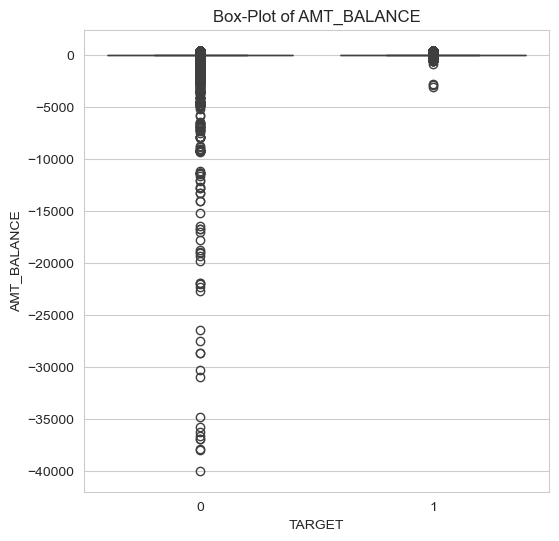

----------------------------------------------------------------------------------------------------


In [42]:
print_percentiles(cc_balance_merged, 'AMT_BALANCE', percentiles = list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(cc_balance_merged, 'AMT_BALANCE', plots = ['box'], figsize = (6, 6), scale_limits = [-40000, 400])
print('-' * 100)

- Distribution of Continuous Variable `CNT_INSTALMENT_MATURE_CUM`

----------------------------------------------------------------------------------------------------
The 0th percentile value of CNT_INSTALMENT_MATURE_CUM is 0.0
The 2th percentile value of CNT_INSTALMENT_MATURE_CUM is 0.0
The 4th percentile value of CNT_INSTALMENT_MATURE_CUM is 0.0
The 6th percentile value of CNT_INSTALMENT_MATURE_CUM is 0.0
The 8th percentile value of CNT_INSTALMENT_MATURE_CUM is 0.0
The 10th percentile value of CNT_INSTALMENT_MATURE_CUM is 0.0
The 25th percentile value of CNT_INSTALMENT_MATURE_CUM is 5.0
The 50th percentile value of CNT_INSTALMENT_MATURE_CUM is 16.0
The 75th percentile value of CNT_INSTALMENT_MATURE_CUM is 33.0
The 100th percentile value of CNT_INSTALMENT_MATURE_CUM is 120.0
----------------------------------------------------------------------------------------------------


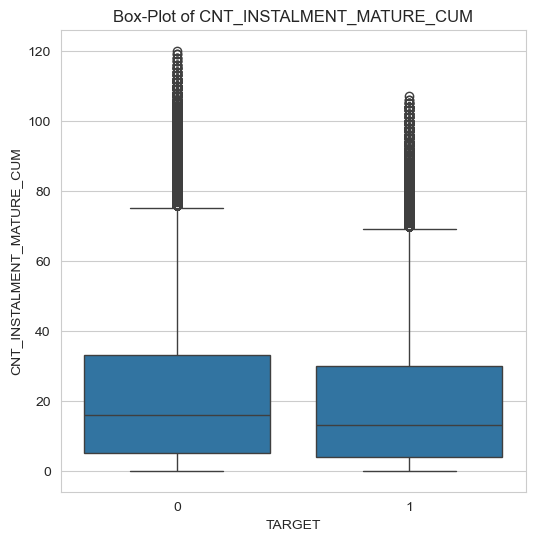

----------------------------------------------------------------------------------------------------


In [43]:
print_percentiles(cc_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', percentiles = list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(cc_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (6, 6), scale_limits = [-40000, 400])
print('-' * 100)

**Note**: From the above plot, we see a very interesting behaviour. This plot shows that the Non-Defaulters (0) usually had higher range of values for the number of installments paid as compared to Defaulters (1). This might show the defaulting behaviour, where in the defaulters usually would pay fewer number of installments on their previous credit.

**5. Correlation Matrix of Features**

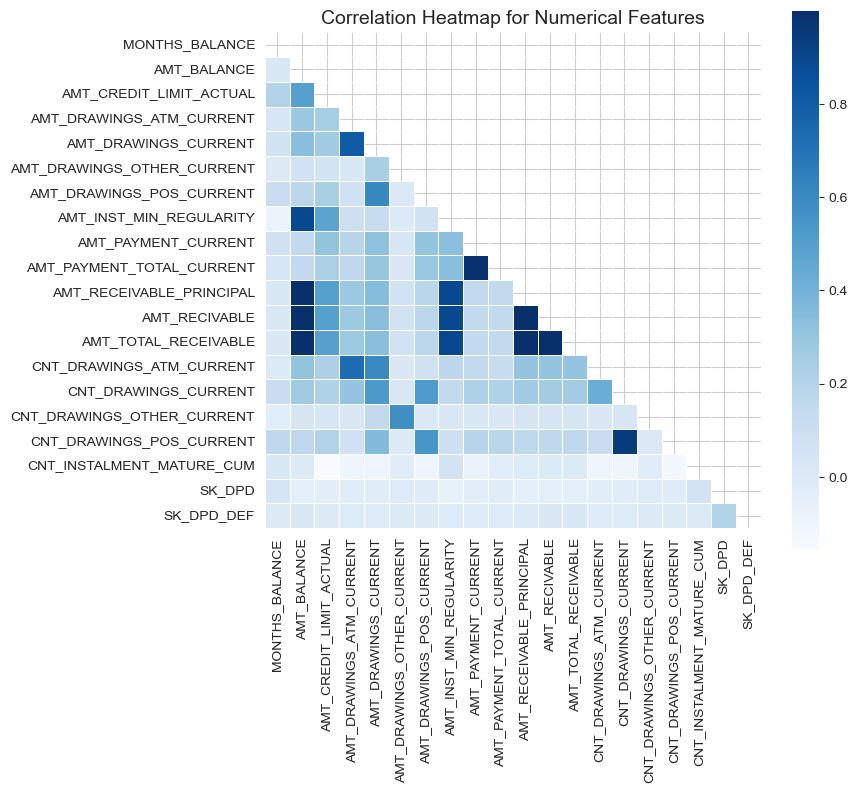

In [44]:
features = ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
            'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
            'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT',
           'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
           'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
           'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM',
            'SK_DPD', 'SK_DPD_DEF']

correlation_heatmap(cc_balance_merged, features, figsize=(8, 7), cmap='Blues', annot=False)

From the heatmap of correlation matrix, we see a few couples of highly correlated features. These are:
- AMT_RECEIVABLE_PRINCIPAL, AMT_RECEIVABLE, AMT_TOTAL_RECEIVABLE and AMT_BALANCE
- We also observe high correlation between these 3 AMT_RECEIVABLE columns
- AMT_PAYMENT_TOTAL_CURRENT and AMT_PAYMENT_CURRENT